In [1]:
import os
import pandas as pd
import numpy as np
import scipy.stats as stats


from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import RepeatedStratifiedKFold

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
cwd = os.getcwd()
BASE_DIR = os.path.abspath(os.path.join(cwd, ".."))

# build paths inside the repo
get_data_path = lambda folders, fname: os.path.normpath(
    os.path.join(BASE_DIR, *folders, fname)
)

file_path_training_data = get_data_path(['output', 'models'], 'training_data.csv')

figure_path_a = get_data_path(['figures'], '2a_network_barplot.png')
figure_path_b = get_data_path(['figures'], '2b_network_boxplot.png') 

In [3]:
# load dataframe
df = pd.read_csv(file_path_training_data)
df.head()

,genepair,A1,A2,A1_entrez,A2_entrez,DepMap_ID,cell_line,Gemini_FDR,raw_LFC,SL,...,colocalisation,interact,n_total_ppi,fet_ppi_overlap,gtex_spearman_corr,gtex_min_mean_expr,gtex_max_mean_expr,GEMINI,LFC,SL_new
0,A3GALT2_ABO,A3GALT2,ABO,127550,28,ACH-000022,PATU8988S_PANCREAS,0.998944,0.088856,False,...,0.0,False,3.0,0.0,0.114847,0.258739,11.702,0.118768,0.088856,False
1,A3GALT2_ABO,A3GALT2,ABO,127550,28,ACH-000307,PK1_PANCREAS,0.986587,0.201704,False,...,0.0,False,3.0,0.0,0.114847,0.258739,11.702,0.132501,0.201704,False
2,A3GALT2_ABO,A3GALT2,ABO,127550,28,ACH-000632,HS944T_SKIN,1.000000,0.069772,False,...,0.0,False,3.0,0.0,0.114847,0.258739,11.702,0.024593,0.069772,False
3,A3GALT2_ABO,A3GALT2,ABO,127550,28,ACH-000681,A549_LUNG,0.977988,0.379455,False,...,0.0,False,3.0,0.0,0.114847,0.258739,11.702,-0.241323,0.379455,False
4,A3GALT2_ABO,A3GALT2,ABO,127550,28,ACH-000756,GI1_CENTRAL_NERVOUS_SYSTEM,0.999586,-0.077118,False,...,0.0,False,3.0,0.0,0.114847,0.258739,11.702,0.299715,-0.077118,False


### Individual Feature Analysis: Predictive Power of Network related Features

### Bar plot

This section visualizes the predictive power (ROC AUC and PR AUC) of individual network-based features. 

The resulting bar plot helps identify which features independently contribute most to the prediction of synthetic lethality.

In [9]:
features_dict = [
    {"name": "ranked_BioGRID_ALL", "label": "Essentiality of Shared PPIs (BG_ALL)", "category": "essentiality"},
    {"name": "weighted_PPI_essentiality", "label": "Essentiality of Shared wPPIs", "category": "essentiality"},
    {"name": "smallest_GO_ranked_ess", "label": "GO BP Essentiality (smallest)", "category": "essentiality"},
    {"name": "smallest_GO_CC_ranked_ess", "label": "GO CC Essentiality (smallest)", "category": "essentiality"},
    {"name": "weighted_PPI_expression", "label": "Expression of Shared wPPIs", "category": "expression"},
    {"name": "smallest_gene_expression", "label": "GO BP Expression (smallest)", "category": "expression"},
    {"name": "go_CC_expression", "label": "GO CC Expression (smallest)", "category": "expression"},
    {"name": "min_sequence_identity", "label": "Sequence Identity", "category": "sequence"},
]

# Extract specific information dynamically if needed
feature_columns = [f["name"] for f in features_dict]
labels = [f["label"] for f in features_dict]
categories = [f["category"] for f in features_dict]

# Target column
target_column = "SL_new"


In [10]:
def calculate_predictive_power(df, feature_columns, target_column, labels, categories):
    data, target = df[feature_columns], df[target_column].values

    n_folds = 5
    n_repeats = 10
    rskf = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=n_repeats, random_state=42)

    mean_aucs = []
    mean_prs = []

    pos_directions = []
    neg_directions = []

    baseline_pr_auc = np.sum(target) / len(target)
    print(f'Baseline PR AUC: {baseline_pr_auc:.4f}')

    for feature_name in feature_columns:
        feature_raw = data[feature_name]

        # Remove NaNs — mask for non-NaN entries
        valid_mask = ~feature_raw.isna()
        feature = feature_raw[valid_mask].values
        target_clean = target[valid_mask]

        # Skip feature if there's not enough data left
        if len(feature) < 2 or len(np.unique(target_clean)) < 2:
            print(f'Skipping feature {feature_name}: insufficient data after removing NaNs.')
            mean_aucs.append(np.nan)
            mean_prs.append(np.nan)
            continue

        # Flip direction if needed
        pos_direction = roc_auc_score(target_clean, feature)
        neg_direction = roc_auc_score(target_clean, -feature)

        pos_directions.append(pos_direction)
        neg_directions.append(neg_direction)

        if neg_direction > pos_direction:
            feature = -feature

        aucs, aps = [], []

        for train_index, test_index in rskf.split(feature, target_clean):
            y_train, y_test = target_clean[train_index], target_clean[test_index]
            x_train, x_test = feature[train_index], feature[test_index]

            if len(np.unique(y_test)) < 2:
                continue  # Skip fold if it has only one class

            try:
                auc = roc_auc_score(y_test, x_test)
                ap = average_precision_score(y_test, x_test)
                aucs.append(auc)
                aps.append(ap)
            except ValueError:
                continue

        mean_auc = np.mean(aucs) if aucs else np.nan
        mean_pr = np.mean(aps) if aps else np.nan

        mean_aucs.append(mean_auc)
        mean_prs.append(mean_pr)

        print(f'Mean ROC AUC for feature {feature_name}: {mean_auc:.4f}')
        print(f'Mean PR AUC for feature {feature_name}: {mean_pr:.4f}')

    pred_df = pd.DataFrame({
        'feature': feature_columns,
        'mean_roc_auc': mean_aucs,
        'avg_precision': mean_prs,
        'label': labels,
        'category': categories,
         'pos_direction': pos_directions,
        'neg_direction': neg_directions
    }).sort_values(by='mean_roc_auc', ascending=False).reset_index(drop=True)

    if pred_df['mean_roc_auc'].notna().any():
        max_roc_auc_feature = pred_df.loc[pred_df['mean_roc_auc'].idxmax()]
        print(f'Feature with the max ROC AUC: {max_roc_auc_feature["feature"]} ({max_roc_auc_feature["mean_roc_auc"]:.4f})')

    if pred_df['avg_precision'].notna().any():
        max_pr_feature = pred_df.loc[pred_df['avg_precision'].idxmax()]
        print(f'Feature with the max avg precision: {max_pr_feature["feature"]} ({max_pr_feature["avg_precision"]:.4f})')

    return pred_df

In [11]:
pred_df = calculate_predictive_power(df, feature_columns, target_column, labels, categories)
pred_df

Baseline PR AUC: 0.0232
Mean ROC AUC for feature ranked_BioGRID_ALL: 0.5806
Mean PR AUC for feature ranked_BioGRID_ALL: 0.0342
Mean ROC AUC for feature weighted_PPI_essentiality: 0.6674
Mean PR AUC for feature weighted_PPI_essentiality: 0.0419
Mean ROC AUC for feature smallest_GO_ranked_ess: 0.6070
Mean PR AUC for feature smallest_GO_ranked_ess: 0.0571
Mean ROC AUC for feature smallest_GO_CC_ranked_ess: 0.5659
Mean PR AUC for feature smallest_GO_CC_ranked_ess: 0.0449
Mean ROC AUC for feature weighted_PPI_expression: 0.6574
Mean PR AUC for feature weighted_PPI_expression: 0.0432
Mean ROC AUC for feature smallest_gene_expression: 0.6017
Mean PR AUC for feature smallest_gene_expression: 0.0700
Mean ROC AUC for feature go_CC_expression: 0.5651
Mean PR AUC for feature go_CC_expression: 0.0546
Mean ROC AUC for feature min_sequence_identity: 0.5463
Mean PR AUC for feature min_sequence_identity: 0.0434
Feature with the max ROC AUC: weighted_PPI_essentiality (0.6674)
Feature with the max avg pr

,feature,mean_roc_auc,avg_precision,label,category,pos_direction,neg_direction
0,weighted_PPI_essentiality,0.667415,0.041874,Essentiality of Shared wPPIs,essentiality,0.332595,0.667405
1,weighted_PPI_expression,0.657419,0.043151,Expression of Shared wPPIs,expression,0.657385,0.342615
2,smallest_GO_ranked_ess,0.606999,0.057130,GO BP Essentiality (smallest),essentiality,0.393026,0.606974
3,smallest_gene_expression,0.601744,0.069968,GO BP Expression (smallest),expression,0.601740,0.398260
4,ranked_BioGRID_ALL,0.580622,0.034154,Essentiality of Shared PPIs (BG_ALL),essentiality,0.419360,0.580640
5,smallest_GO_CC_ranked_ess,0.565932,0.044883,GO CC Essentiality (smallest),essentiality,0.434041,0.565959
6,go_CC_expression,0.565060,0.054648,GO CC Expression (smallest),expression,0.565095,0.434905
7,min_sequence_identity,0.546313,0.043379,Sequence Identity,sequence,0.546278,0.453722


In [7]:
no_skill = round(sum(df['SL_new']) / len(df['SL_new']), 2)
no_skill

0.02

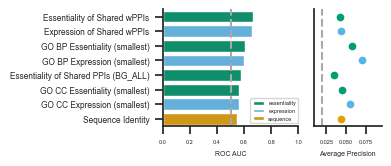

In [12]:
def plot_roc_pr(pred_df):
    sns.set_theme(style="ticks")

    f, ax = plt.subplots(ncols=2, nrows=1, figsize=(3.95, 1.7), sharey=True, gridspec_kw={'width_ratios': [2, 1]})
    
    colors = ["#009E73", "#56B4E9", '#E69F00']
    sns.set_palette(sns.color_palette(colors))

    sns.barplot(data=pred_df, x='mean_roc_auc', y='label', hue='category', palette=colors, saturation=0.8, dodge=False, ax=ax[0])
    ax[0].set_xlabel('ROC AUC', size=5) 
    ax[0].set_ylabel('')
    ax[0].set_xlim(0, 1)
    ax[0].tick_params('x', labelsize=4)
    ax[0].tick_params('y', labelsize=6)
    ax[0].axvline(x=0.5, linestyle='--', color='darkgrey')
    ax[0].legend(loc='lower right', fontsize=4, bbox_to_anchor=(1.02, 0))

    sns.pointplot(data=pred_df, x='avg_precision', y='label', hue='category', palette=colors,
                  dodge=False, markers='o', linestyles='none', errorbar=None, ax=ax[1])
    for line in plt.gca().lines:
        line.set_markersize(3.5)
    ax[1].set_xlabel('Average Precision', size=5) 
    ax[1].set_xlim(pred_df['avg_precision'].min()-0.025, pred_df['avg_precision'].max()+0.025)
    
    # Remove y-ticks for ax[1]
    ax[1].tick_params('y', left=False, labelleft=False)
    ax[1].tick_params('x', labelsize=4)
    ax[1].axvline(x=no_skill, linestyle='--', color='darkgrey')
    ax[1].legend().remove()

    # Remove top and right borders
    sns.despine(ax=ax[0], top=True, right=True)
    sns.despine(ax=ax[1], top=True, right=True)

    plt.tight_layout(pad=0.7)
    #plt.show()
    plt.savefig(figure_path_a, bbox_inches="tight", dpi=300)

plot_roc_pr(pred_df)

### Box Plot

In [24]:
box_feature_ppi = ['ranked_BioGRID_ALL', 'weighted_PPI_essentiality', 
                   'smallest_GO_ranked_ess', 'smallest_GO_CC_ranked_ess',
                   'smallest_gene_expression', 'go_CC_expression',
                   'weighted_PPI_expression', 'min_sequence_identity']
box_labels_ppi = ['Essentiality of Shared PPIs (BG_ALL)', 'Essentiality of Shared wPPIs', 
                  'GO BP Essentiality (smallest)', 'GO CC Essentiality (smallest)',
                  'GO BP Expression (smallest)', 'GO CC Expression (smallest)',
                  'Expression of Shared wPPIs',  'Sequence Identity']

display(dict(zip(box_feature_ppi, box_labels_ppi)))

{'ranked_BioGRID_ALL': 'Essentiality of Shared PPIs (BG_ALL)',
 'weighted_PPI_essentiality': 'Essentiality of Shared wPPIs',
 'smallest_GO_ranked_ess': 'GO BP Essentiality (smallest)',
 'smallest_GO_CC_ranked_ess': 'GO CC Essentiality (smallest)',
 'smallest_gene_expression': 'GO BP Expression (smallest)',
 'go_CC_expression': 'GO CC Expression (smallest)',
 'weighted_PPI_expression': 'Expression of Shared wPPIs',
 'min_sequence_identity': 'Sequence Identity'}

In [25]:
def draw_signif_line(ax, x0, x1, y, pval, hd=20):
    """Draws a significance line between two box plots."""
    h = y / hd
    if pval < 0.0001: 
        text = '$p$=%.1e' % pval
    else: 
        text = '$p$=%.4f' % pval
    ax.plot([x0, x0, x1, x1], [y + h, y + 2 * h, y + 2 * h, y + h], lw=1, c='#666')
    ax.text((x0 + x1) * .5, y + 2.5 * h, text, ha='center', va='bottom', color='#666', fontsize=5)

In [26]:
def compute_upper_whisker(df, feature):
    """Computes the upper whisker of a box plot for a given feature."""
    Q1 = df[feature].quantile(q=0.25)
    Q3 = df[feature].quantile(q=0.75)
    IQR = Q3 - Q1
    return df[df[feature] <= (Q3 + 1.5 * IQR)][feature].max()

In [27]:
def draw_cont_graph(df, feature, target_column, ax, label=None, fliers=True, show_points=True, draw_signif=True, hd=20):
    # Define the color palette based on feature names
    color_mapping = {
        'ranked_BioGRID_ALL': '#009E73',
        'weighted_PPI_essentiality': '#009E73',
        'smallest_GO_ranked_ess': '#009E73',
        'smallest_GO_CC_ranked_ess': '#009E73',
        'smallest_gene_expression': '#56B4E9',
        'go_CC_expression': '#56B4E9',
        'weighted_PPI_expression': '#56B4E9',
        'min_sequence_identity': '#E69F00'
    }

    # Set the colors for False and True based on the feature
    true_color = color_mapping.get(feature, '#8491B4FF')  # default to original color if feature not in mapping
    my_pal = {False: "white", True: true_color}

    # Calculate the counts of SL and not_SL
    count_SL = (df[target_column] == True).sum()
    count_not_SL = (df[target_column] == False).sum()
    
    sns.despine(top=True, right=True, left=False, bottom=False)
    sns.boxplot(y=feature, x=target_column, hue=target_column, data=df, ax=ax, linewidth=0.8, saturation=0.8, 
                showfliers=False, showmeans=False, palette=my_pal, order=[False, True], 
                boxprops={'edgecolor':'black', 'alpha':0.85}, medianprops={'color':'black', 'linewidth':0.8})
    
    ax.set_ylabel(label if label else feature, fontsize=5.75)
    ax.set_xlabel('')
    ax.set_xticks([0, 1])
    ax.set_xticklabels([f'not_SL \n(n={count_not_SL})', f'SL \n(n={count_SL})'], fontsize=6)
    ax.tick_params(axis='y', rotation=0, labelsize=4)
    ax.legend().remove()

    #if show_points:
    #    sns.stripplot(y=feature, x=target_column, data=df, color='silver', ax=ax, alpha=0.7, size=2, zorder=0)
    #    ax.set_xlabel('')
    #    ax.legend().remove()

    if draw_signif:
        pval = stats.mannwhitneyu(df.loc[df[target_column] == True, feature], df.loc[df[target_column] == False, feature], alternative="two-sided")[1]
        upper_whisker = max(compute_upper_whisker(df.loc[df[target_column] == True], feature), compute_upper_whisker(df.loc[df[target_column] == False], feature))
        draw_signif_line(ax, 0, 1, upper_whisker + 0.05, pval, hd)


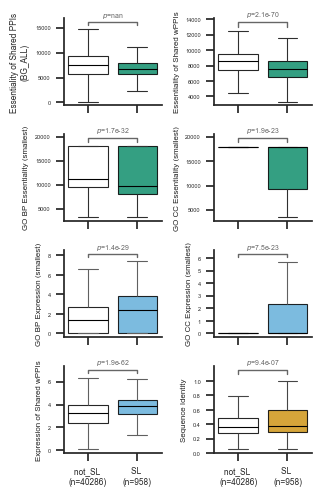

In [28]:
f, ax = plt.subplots(4, 2, figsize=(3.25, 5), sharex=True)  
ax = ax.flatten()
for i in range(len(box_feature_ppi)):
    draw_cont_graph(df, box_feature_ppi[i], target_column, ax[i], label=box_labels_ppi[i])

ax[0].set_ylabel('Essentiality of Shared PPIs \n(BG_ALL)', fontsize=6)
ax[7].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])

plt.tight_layout(pad=0.7)
f.savefig(figure_path_b, bbox_inches="tight", dpi=300)
#plt.show()  